# simple k-space trajectory optimization based on SNOPY
**paper:**\
Wang G, Nielsen JF, Fessler JA, Noll DC.\
Stochastic optimization of three-dimensional non-Cartesian sampling trajectory\
Magnetic Resonance in Medicine. 2023;90(2):417-431. https://dx.doi.org/10.1002/mrm.29645

**original code:** https://github.com/guanhuaw/SNOPY

**see also:**
https://archive.ismrm.org/2021/4200.html


## setup

In [1]:
# general setup
import os
import sys
if not os.path.isdir('SNOPY'):
    !git clone https://github.com/guanhuaw/SNOPY.git
sys.path.append('./SNOPY')

if not os.path.isdir('out'):
  os.mkdir('./out')

datapath = './data/testdata.mat'

# colab-specific setup
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip install torchkbnufft
    !pip install mirtorch
    !pip install git+https://github.com/cetmann/iunets/
    if not os.path.isdir('./traj_learning_demo/'):
        !git clone https://github.com/fglang/traj_learning_demo.git
    sys.path.append('./traj_learning_demo/')
    datapath = './traj_learning_demo/data/testdata.mat'

Cloning into 'SNOPY'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 54 (delta 1), reused 4 (delta 1), pack-reused 45 (from 1)
Receiving objects: 100% (54/54), 21.38 MiB | 7.90 MiB/s, done.
Resolving deltas: 100% (5/5), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.3 MB/s eta 0:00:00
  Cloning https://github.com/cetmann/iunets/ to /tmp/pip-req-build-o4n73_ss
  Running command git clone --filter=blob:none --quiet https://github.com/cetmann/iunets/ /tmp/pip-req-build-o4n73_ss
  Resolved https://github.com/cetmann/iunets/ to commit 80ed7cce0e505a0396c42359eaf27819222d71f6
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 14.6 MB/s eta 0:00:00
  Created wheel for iunets: filename=iunets-0.1-py3-none-any.whl size=21663 sha256=0cb56ea25d3464a15bc124bad

In [2]:
import time
from SimpleQPWLS_model import SimpleQPWLSModel
from models.mirtorch_pkg import NuSense_om
from types import SimpleNamespace
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from tools import *
from IPython.display import clear_output

/usr/local/lib/python3.12/dist-packages/memcnn/models/revop.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float32)
/usr/local/lib/python3.12/dist-packages/memcnn/models/revop.py:73: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


## initialize trajectory

### radial in-out

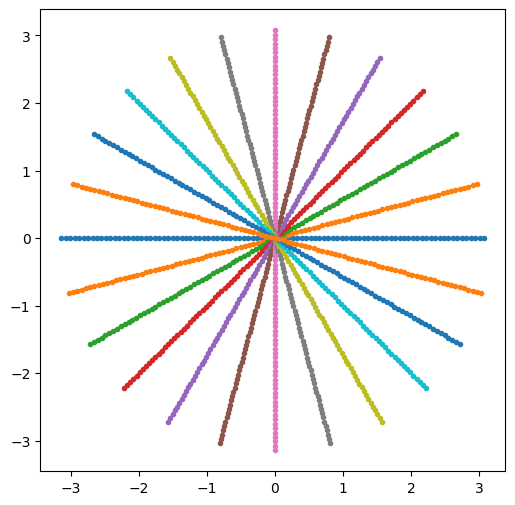

In [3]:
# trajectory initialization: radial in-out
nx = 48 # image
nread = nx * 2
nshot = nx // 4 # accel

phi = np.arange(0, np.pi, np.pi/nshot)
kx0 = np.arange(-np.pi, +np.pi, 2*np.pi/nread) # asymmetric, hit center
# kx0 = np.linspace(-np.pi, +np.pi, nread) # symmetric, miss center

kx = kx0.reshape(1,nread) * np.cos(phi).reshape(nshot,1)
ky = kx0.reshape(1,nread) * np.sin(phi).reshape(nshot,1)
kz = np.zeros(kx.shape)

k = np.stack([kx.flatten(), ky.flatten(), kz.flatten()], 0) # assumed convention: shots x read

plt.figure(figsize=(6,6))
for jj in range(nshot):
    plt.plot(kx[jj,:],ky[jj,:],'.-')

fname_traj = './radial.npy'
np.save(fname_traj, arr=k)

### radial out

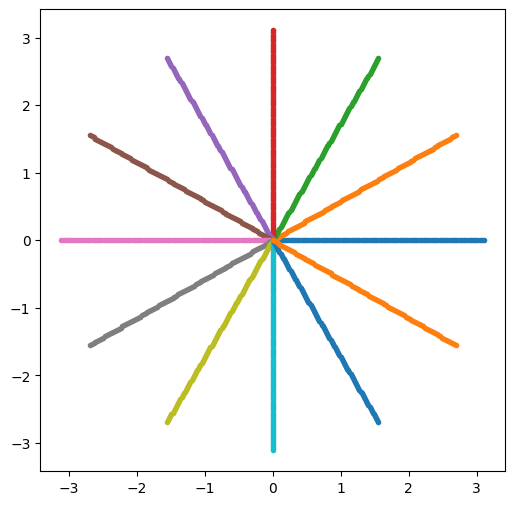

In [4]:
# trajectory initialization: radial out
nx = 48 # image
nread = nx * 2
nshot = nx // 4 # accel

phi = np.arange(0, 2*np.pi, 2*np.pi/nshot)
kx0 = np.arange(0, +np.pi, np.pi/nread) # asymmetric, hit center
# kx0 = np.linspace(-np.pi, +np.pi, nread) # symmetric, miss center

kx = kx0.reshape(1,nread) * np.cos(phi).reshape(nshot,1)
ky = kx0.reshape(1,nread) * np.sin(phi).reshape(nshot,1)
kz = np.zeros(kx.shape)

k = np.stack([kx.flatten(), ky.flatten(), kz.flatten()], 0) # assumed convention: shots x read

plt.figure(figsize=(6,6))
for jj in range(nshot):
    plt.plot(kx[jj,:],ky[jj,:],'.-')

fname_traj = './radial.npy'
np.save(fname_traj, arr=k)

## settings

In [8]:
opt = SimpleNamespace()

# basics params
opt.which_model_netD_I = 'samplingBspline'
opt.model = 'SimpleQPWLS' # demo model, 2D SENSE
opt.gpu_ids = [0]
opt.name = 'simpleSNOPY'

# training params
opt.niter = 200 # numbe rof iterations
opt.niter_decay = 200 # control learning rate decay
opt.lr_traj = 5e-2 # learning rate for k-space trajectory
opt.lr_policy = 'lambda' # strategy for learning rate schedule
opt.sgld = False # False -> Adam

# regularization parameters for balancing loss terms
opt.loss_content_I_l1 = 0 # L1 loss (truth - reco)
opt.loss_content_I_l2 = 400 # L2 loss (truth - reco)
opt.loss_slew = 1 # slew rate penalty
opt.loss_grad = 1 # grad ampl penalty
opt.fix_first_k0 = False

# reco parameters
opt.noise_level = 0.005 # inject Gaussian noise during training
opt.num_blocks = 10 # number of CG SENSE reco iterations (inner loop)
opt.CGtol = 0.0005 # CG SENSE param
opt.CGlambda = 0.001 # CG SENSE param
opt.use_rough = False # roughness penalty, L2 of finite differences, Tikhonov type
opt.grid_size = 2 # NUFFT grid oversampling
opt.numpoints = 6 # NUFFT

# trajectory parameters
opt.gradmax = 5 # Gauss/cm [=10mT/m]
opt.slewmax = 18000 # Gauss/cm/s [=0.01T/m/s]
opt.iso_constraint = False # gradient constraint for all possible orientations?
opt.decim_rate = 4 # how many trajectory samples controlled by one spline coefficient, 1: no splines
opt.padding = 200 # for b-spline representation at the edges of each shot interval
opt.dt = 2e-5 # BWperPixel = 1/(opt.dt*nread)
opt.resx = 0.2 # cm
opt.resy = 0.2 # cm
opt.resz = 1 # cm



In [10]:
# book keeping, set previously
opt.mask_path = fname_traj
opt.nx = nx
opt.ny = nx
opt.nz = 1
opt.num_shots = nshot
opt.nfe = nread

# more misc params (required by SNOPY framework, but not used in this simple demo)
opt.save_latest_freq = 5000
opt.save_epoch_freq = 40
opt.val_epoch_freq = 40
opt.phase = 'train'
opt.train_phase = 'generator'
opt.which_epoch = 'latest'

opt.dataroot = None
opt.batchSize = 1
opt.checkpoints_dir = './checkpoints'

opt.verbose = True
opt.suffix = 'simpleSNOPY'

opt.isTrain = True
opt.resize_or_crop = False
opt.init_type = 'normal'
opt.init_gain = 0.02
opt.norm = 'instance'
opt.beta1 = 0.5
opt.contrast_condition = None
opt.epoch_count = 1
opt.continue_train = False
opt.loss_pi = 0
opt.ReconVSTraj = 1 # scaling factor of trajectory learning rate

## run iterations

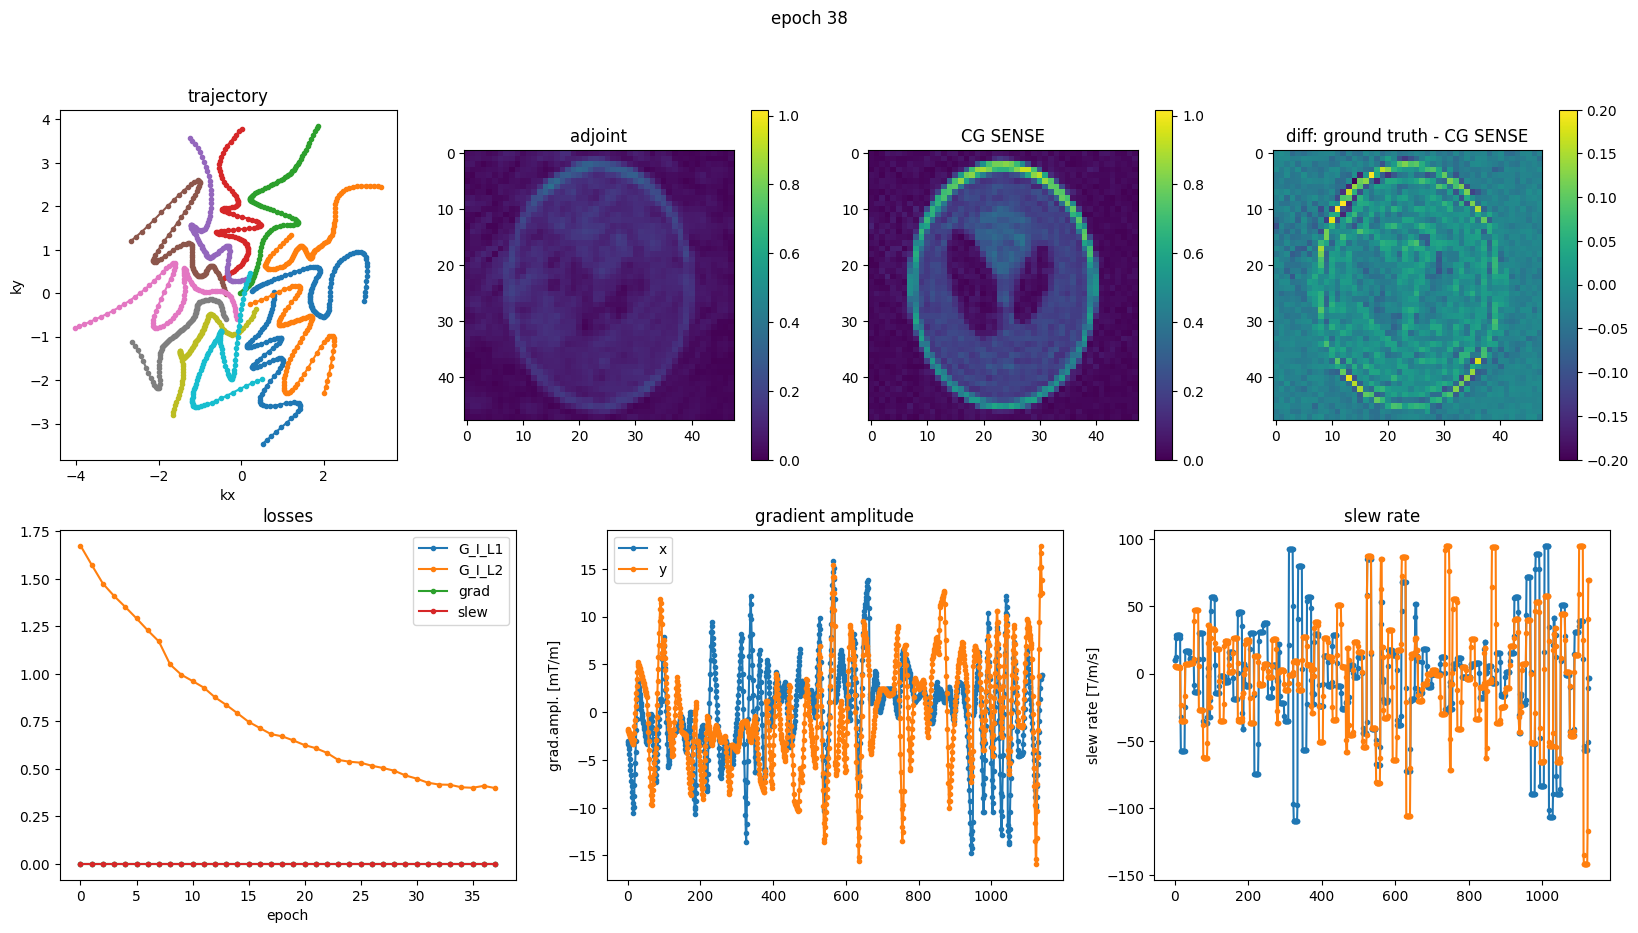

KeyboardInterrupt: 

In [11]:
model = SimpleQPWLSModel()
model.initialize(opt)
model.setup(opt)

for epoch in range(0, opt.niter):

    # learn on single dataset for demo, (more advanced: replace by dataloader)
    model.set_input(datapath)

    # learning step
    model.optimize_parameters()
    torch.cuda.reset_peak_memory_stats()

    # keep track of all loss values over epochs
    if epoch == 0:
        all_losses = dict()
        for loss_name in model.loss_names:
            all_losses[loss_name] = []
    else:
        current_losses = model.get_current_losses()
        for loss_name in model.loss_names:
            all_losses[loss_name].append(current_losses[loss_name])

    # visualize current state
    clear_output(wait=True)
    plot_epoch(model, opt, all_losses, epoch)



## simple eddy current simulation
assuming the following model:
$$ \mathbf{G}(t)=\mathbf{g}(t)-\dot{\mathbf{g}}(t)\otimes \Theta (t){\sum}_n{\alpha}_n\exp \left(-\frac{t}{\tau_n}\right) $$
with actually realized gradient waveforms $\mathbf{G}(t)$, nominal waveforms $\mathbf{g}(t)$, slew rate $\dot{\mathbf{g}}(t)$, Heaviside step function $\Theta (t)$.

see e.g. Jehenson et al., https://dx.doi.org/10.1016/0022-2364(90)90133-T \
and West et al., https://dx.doi.org/10.1002/mrm.70093

Text(0.5, 0.98, 'eddy ampl=1e-06')

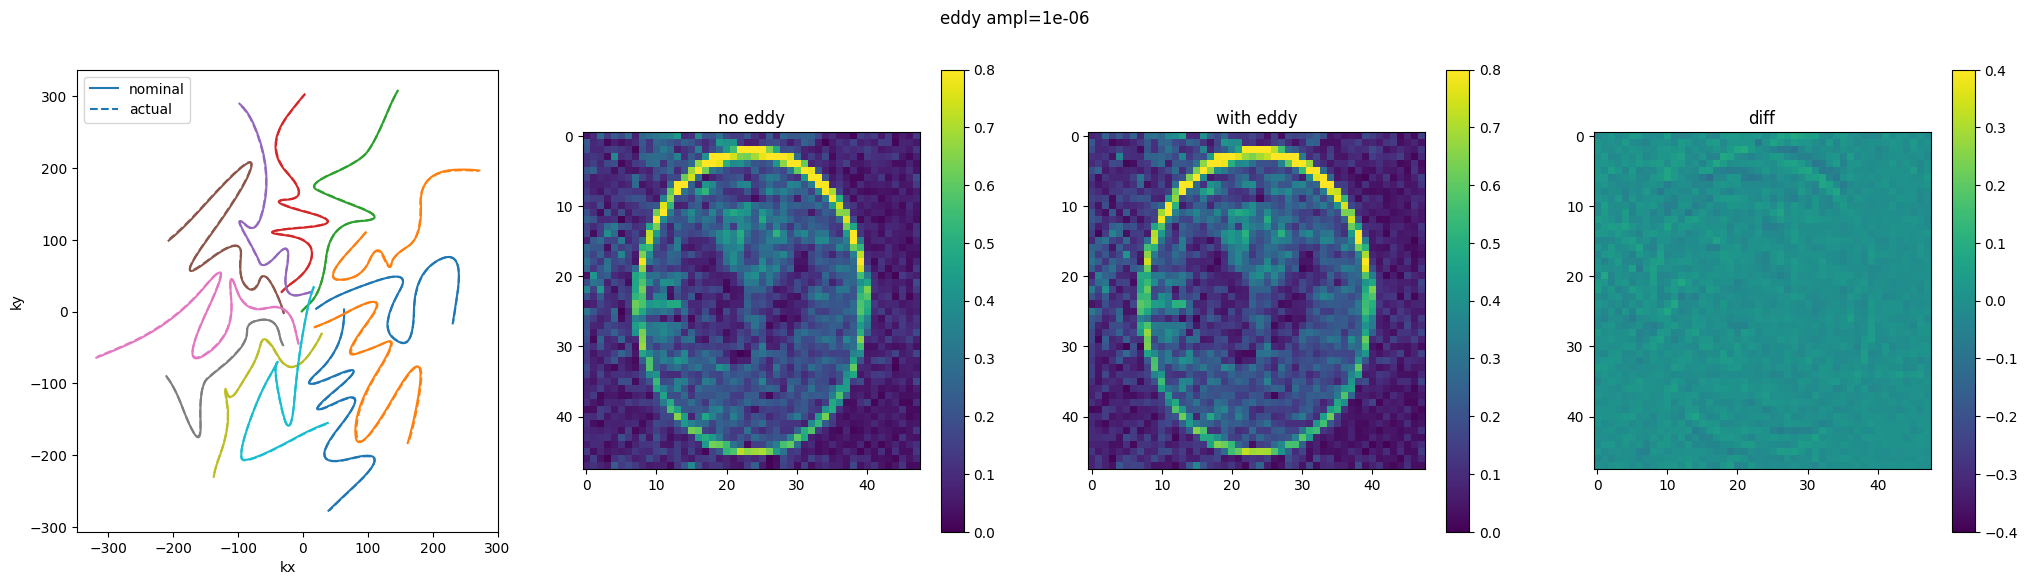

In [13]:
ampl = 1e-6 # scaling the strength of eddy current effect
alphas = [1,     0] # relative amplitudes of EC components
taus =   [50e-6, 1e-1] # time constants

k_nominal = traj2phys(model.ktraj.reshape(2,opt.num_shots,opt.nfe), res=opt.resx*1e-2).detach()
k_perturbed = eddy_perturbation(k_nominal, opt, ampl=ampl, alphas=alphas, taus=taus)

# simulate with nominal and perturbed trajectories

model.set_input(datapath)

# SENSE operator with nominal trajectory
A = NuSense_om(model.smap, model.ktraj, numpoints=opt.numpoints, grid_size=opt.grid_size,
                    norm='ortho')
# unperturbed data
kunder = A * (model.Ireal)
# reconstruct with nominal traj -> no mismatch
reco = (model.P * (A.H * kunder)).squeeze() # model.P is the "inverse gram operator", approximating inv(A.H @ A) by CG iterations

# forward operator with PERTURBED traj
A_perturbed = NuSense_om(model.smap, traj2norm(k_perturbed, res=opt.resx*1e-2).reshape(1,2,-1),
                        numpoints=opt.numpoints, grid_size=opt.grid_size,
                    norm='ortho')
# perturbed data
kunder_perturbed = A_perturbed * (model.Ireal)
# reconstruct with NOMINAL traj -> MISMATCH
reco_perturbed = (model.P * (A.H * kunder_perturbed)).squeeze()



# visualize
diffp = reco.abs() - reco_perturbed.abs()
plt.figure(figsize=(25,6))
plt.subplot(1,4,1)
for jj in range(opt.num_shots):
    h = plt.plot(k_nominal[0,jj,:].cpu(), k_nominal[1,jj,:].cpu(), '-')
    plt.plot(k_perturbed[0,jj,:].cpu(), k_perturbed[1,jj,:].cpu(), '--', color=h[0].get_color())
plt.xlabel('kx'), plt.ylabel('ky'), plt.legend(['nominal', 'actual'])
plt.subplot(1,4,2)
plt.imshow(reco.abs().cpu().detach(), vmin=0, vmax=0.8), plt.colorbar()
plt.title('no eddy')
plt.subplot(1,4,3)
plt.imshow(reco_perturbed.abs().cpu().detach(), vmin=0, vmax=0.8), plt.colorbar()
plt.title(f'with eddy')
plt.subplot(1,4,4)
plt.imshow(diffp.cpu().detach(), vmin=-0.4, vmax=+0.4), plt.colorbar()
plt.title('diff')
plt.suptitle(f'eddy ampl={ampl:.2g}')


# plt.savefig(f'./out/ec/temp{ii:04d}.png')  # Save the plot as a temporary PNG file




